# Testing with generated real data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from dataset import AdSBHDataset
from model import AdSBHNet
from constants import dtype

Generate a dataset.

coef = 1.0
shift = 0.0


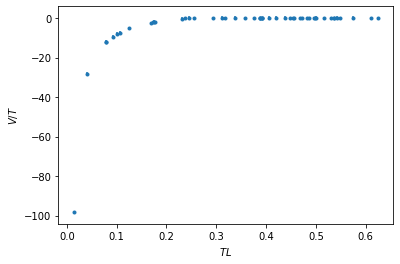

In [2]:
dataset = AdSBHDataset(N=50, threshold=0.0, coef=1.0)
plt.errorbar(dataset.L.numpy(), dataset.V.numpy(), yerr=dataset.sigma.numpy(), fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
print(f'coef = {dataset.coef}')
print(f'shift = {dataset.shift}')

## Consistency check
Learnable parameters set to zero (standard BH).

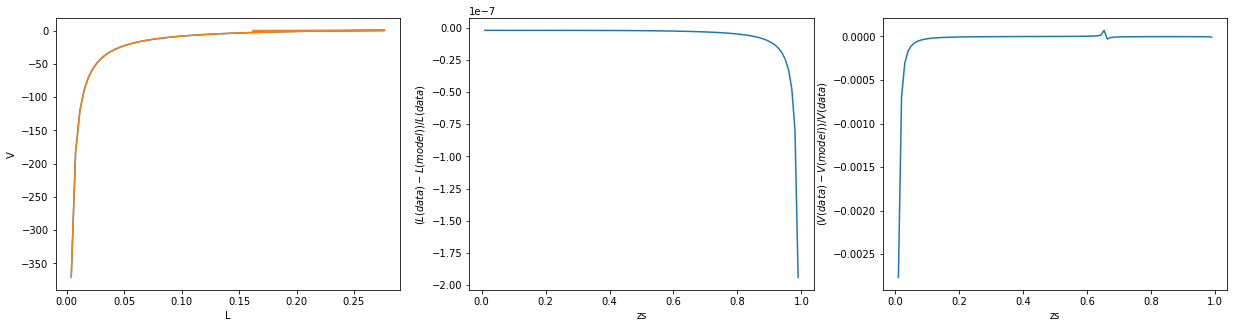

In [3]:
model = AdSBHNet(N=1)
model.a = nn.Parameter(torch.tensor([0.0], dtype=dtype))
model.b = nn.Parameter(torch.tensor([0.0], dtype=dtype))
model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dtype).log())
model.shift = nn.Parameter(torch.tensor(dataset.shift, dtype=dtype))
zs = np.linspace(0.01, 0.99, 100)
d_L = np.array([dataset.integrate_L(z).real for z in zs])
d_V = np.array([dataset.integrate_V(z).real for z in zs])
with torch.no_grad():
    m_L = np.array([model.integrate_L(z).item() for z in zs])
    m_V = np.array([model.integrate_V(z).item() for z in zs])
fig, axs = plt.subplots(1, 3, figsize=(21, 5))
axs[0].plot(d_L, d_V)
axs[0].plot(m_L, m_V)
axs[0].set_xlabel('L')
axs[0].set_ylabel('V')
axs[1].plot(zs, (d_L-m_L)/d_L)
axs[1].set_xlabel('zs')
axs[1].set_ylabel(r'$(L(data)-L(model))/L(data)$')
axs[2].plot(zs, (d_V-m_V)/d_V)
axs[2].set_xlabel('zs')
axs[2].set_ylabel(r'$(V(data)-V(model))/V(data)$');

Let's check that $a=b=0$ is a local minimum of the loss function

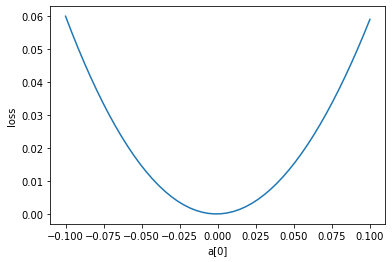

In [4]:
A = np.linspace(-0.1, 0.1, 50)
losses = []
model = AdSBHNet(N=1)
for aval in A:
    model.a = nn.Parameter(torch.tensor([aval], dtype=dtype))
    model.b = nn.Parameter(torch.tensor([0.0], dtype=dtype))
    model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dtype).log())
    model.shift = nn.Parameter(torch.tensor(dataset.shift, dtype=dtype))
    loss = torch.mean((model(dataset.L) - dataset.V)**2)
    losses.append(loss.item())
plt.plot(A, losses)
plt.xlabel('a[0]')
plt.ylabel('loss');

Check that gradients agree with finite difference derivatives.

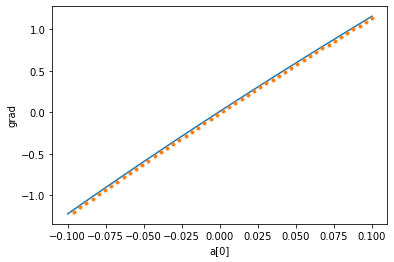

In [5]:
grads = []
model = AdSBHNet(N=1)
for aval in A:
    model.a = nn.Parameter(torch.tensor([aval], dtype=dtype))
    model.b = nn.Parameter(torch.tensor([0.0], dtype=dtype))
    model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dtype).log())
    model.shift = nn.Parameter(torch.tensor(dataset.shift, dtype=dtype))
    model.zero_grad()
    loss = torch.mean((model(dataset.L) - dataset.V)**2)
    loss.backward()
    grads.append(model.a.grad[0].item())
plt.plot(A, grads)
plt.plot(A[1:], (np.array(losses[1:])-np.array(losses[:-1]))/(A[1]-A[0]), '.')
plt.xlabel('a[0]')
plt.ylabel('grad');

Do the same check w.r.t. $b$.

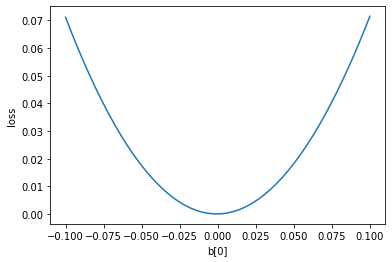

In [6]:
B = np.linspace(-0.1, 0.1, 50)
losses = []
model = AdSBHNet(N=1)
for bval in B:
    model.a = nn.Parameter(torch.tensor([0.0], dtype=dtype))
    model.b = nn.Parameter(torch.tensor([bval], dtype=dtype))
    model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dtype).log())
    model.shift = nn.Parameter(torch.tensor(dataset.shift, dtype=dtype))
    loss = torch.mean((model(dataset.L) - dataset.V)**2)
    losses.append(loss.item())
plt.plot(B, losses)
plt.xlabel('b[0]')
plt.ylabel('loss');

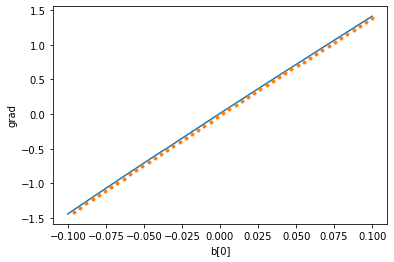

In [7]:
grads = []
model = AdSBHNet(N=1)
for bval in B:
    model.a = nn.Parameter(torch.tensor([0.0], dtype=dtype))
    model.b = nn.Parameter(torch.tensor([bval], dtype=dtype))
    model.logcoef = nn.Parameter(torch.tensor(dataset.coef, dtype=dtype).log())
    model.shift = nn.Parameter(torch.tensor(dataset.shift, dtype=dtype))
    model.zero_grad()
    loss = torch.mean((model(dataset.L) - dataset.V)**2)
    loss.backward()
    grads.append(model.b.grad[0].item())
plt.plot(B, grads)
plt.plot(B[1:], (np.array(losses[1:])-np.array(losses[:-1]))/(B[1]-B[0]), '.')
plt.xlabel('b[0]')
plt.ylabel('grad');

## Training

[Parameter containing:
tensor([-0.0227], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([-0.4043], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(-0.0790, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(0.3124, dtype=torch.float64, requires_grad=True)]
epoch= 0, loss=0.001541
epoch= 1, loss=0.000000
epoch= 2, loss=0.000000
epoch= 3, loss=0.000000
epoch= 4, loss=0.000000
[Parameter containing:
tensor([0.0017], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([-0.0006], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(-0.0003, dtype=torch.float64, requires_grad=True), Parameter containing:
tensor(-8.5774e-06, dtype=torch.float64, requires_grad=True)]


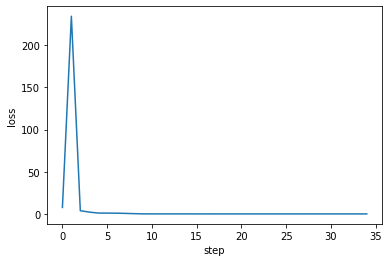

In [8]:
model = AdSBHNet(N=1, std=0.3)

print(list(model.parameters()))
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=len(dataset))

optimizer = torch.optim.LBFGS(model.parameters())
epochs = 5
# optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
# epochs = 500

a_vals, b_vals, coef_vals = [model.a.detach().numpy().copy()], [model.b.detach().numpy().copy()], [model.logcoef.exp().item()]
losses = []

z = torch.linspace(0, 0.95, 50)
fzInit = model.eval_f(z).detach().numpy()
gzInit = model.eval_g(z).detach().numpy()
fz0 = 1 - z**4
gz0 = 1 / fz0

try:
    for epoch in range(epochs):
        for L, V, sigma in loader:
            def closure():
                optimizer.zero_grad()
                V_pred = model(L)
                V_diff = V_pred - V
                loss = torch.mean((model(L) - V)**2 / sigma**2)
                a_vals.append(model.a.detach().numpy().copy())
                b_vals.append(model.b.detach().numpy().copy())
                coef_vals.append(model.logcoef.exp().item())
                loss.backward()
                losses.append(loss.item())
                return loss
            optimizer.step(closure)
        print(f'epoch={epoch:2d}, loss={losses[-1]:0.6f}')
except KeyboardInterrupt:
    print('Stopping.')

fz = model.eval_f(z).detach().numpy()
gz = model.eval_g(z).detach().numpy()
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss')
print(list(model.parameters()))

# Results

The predicted potential in terms of separation.

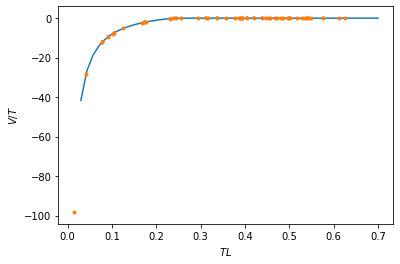

In [9]:
with torch.no_grad():
    L_grid = torch.linspace(0.03, 0.7, 50)
    V_grid = model(L_grid)
plt.plot(L_grid, V_grid)
plt.errorbar(dataset.L, dataset.V, yerr=dataset.sigma, fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$');

Parameter evolution.

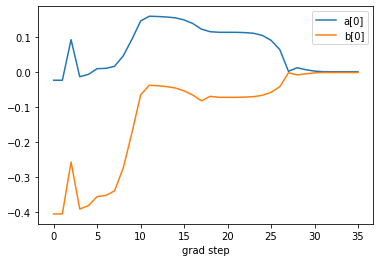

In [10]:
for i in range(len(a_vals[0])):
    plt.plot([a[i] for a in a_vals], label=f'a[{i}]')
for i in range(len(a_vals[0])):
    plt.plot([b[i] for b in b_vals], label=f'b[{i}]')
plt.xlabel('grad step')
plt.legend();

Plot the metric functions. This should converge to BH functions.

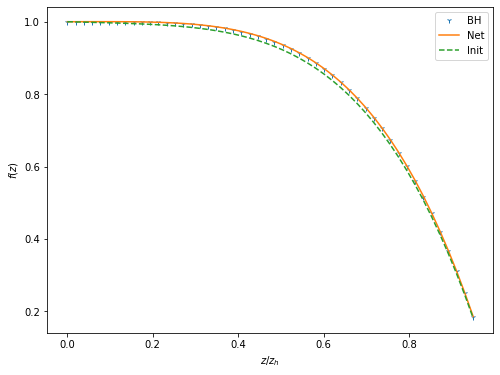

In [11]:
plt.subplots(figsize=(8, 6))
plt.plot(z, fz0, '1', label='BH')
plt.plot(z, fz, label='Net')
plt.plot(z, fzInit, '--', label='Init')
plt.xlabel(f'$z/z_h$')
plt.ylabel(f'$f(z)$')
plt.legend();

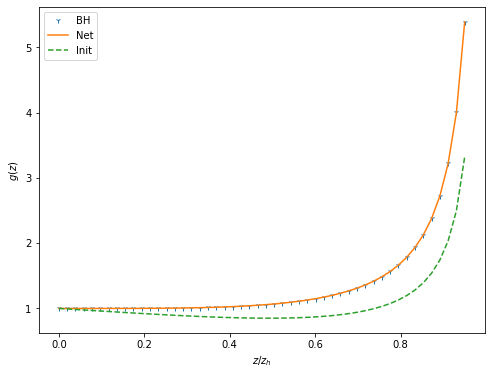

In [12]:
plt.subplots(figsize=(8, 6))
plt.plot(z, gz0, '1', label='BH')
plt.plot(z, gz, label='Net')
plt.plot(z, gzInit, '--', label='Init')
plt.xlabel(f'$z/z_h$')
plt.ylabel(f'$g(z)$')
plt.legend();